# <center><font color="red"> https://bit.ly/brin-2021-B</font></center>

<center><img alt="" src="images/brin/brin-2021-covers.png"/></center> 

## <center><font color="blue">tau-data Indonesia</font><br>(C) Taufik Sutanto - 2021<br>https://tau-data.id</center>

# <center><font color="blue">Jadwal Workshop Digital Skill Untuk Kebencanaan BRIN 2021</font></center>

### <font color="green">Sesi Siang-Sore</font>
5. PreProcessing & Visualisasi Dasar Data Banjir 2021
6. Pemodelan Topik & Analisa HashTag Data Bencana Banjir 2021

><font color="green">"*I always have a basic plot outline, but I like to leave some things to be decided while I write*." ~ J. K. Rowling</font>

<center><img src="images/brin/jadwal-brin-2021.png" /></center>

In [1]:
import warnings; warnings.simplefilter('ignore')
import nltk

try:
    import google.colab
    IN_COLAB = True
    !wget https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/brin.py
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/slang.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/provinsi-latlon-radius.csv
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_id.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_en.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/kata_dasar.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-ind-def.tab
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-msa-all.tab
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/ind_SA.csv
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/all_indo_man_tag_corpus_model.crf.tagger

    !pip install --upgrade spacy python-crfsuite unidecode textblob sastrawi sklearn-pycrfsuite networkx pickle
    !pip install --upgrade unidecode twython tweepy beautifulsoup4 googlemaps pyLDAvis folium gensim wordcloud
    !python -m spacy download en
    !python -m spacy download xx
    !python -m spacy download en_core_web_sm
    nltk.download('popular')
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")

Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded


In [3]:
import brin
import tweepy, json, urllib.request, requests
from urllib.request import Request, urlopen
from twython import TwythonStreamer
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd, folium
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()
from folium.plugins import MarkerCluster, HeatMap
"Done"

'Done'

## Tokenisasi

<p>Tokenisasi adalah pemisahan kata, simbol, frase, dan entitas penting lainnya (yang disebut sebagai token) dari sebuah teks untuk kemudian di analisa lebih lanjut. Token dalam NLP sering dimaknai dengan &quot;sebuah kata&quot;, walau tokenisasi juga bisa dilakukan ke kalimat, paragraf, atau entitas penting lainnya (misal suatu pola string DNA di Bioinformatika).</p>

<p><strong>Mengapa perlu tokenisasi?</strong></p>

<ul>
	<li>Langkah penting dalam preprocessing, menghindari kompleksitas mengolah langsung pada string asal.</li>
	<li>Menghindari masalah (semantic) saat pemrosesan model-model natural language.</li>
	<li>Suatu tahapan sistematis dalam merubah unstructured (text) data ke bentuk terstruktur yang lebih mudah di olah.</li>
</ul>

<p><img alt="" src="images\2_Pipeline_Tokenization.png" style="height:300px; width:768px" /><br />
[<a href="https://www.softwareadvice.com/resources/what-is-text-analytics/" target="_blank"><strong>Image Source</strong></a>]: https://www.softwareadvice.com/resources/what-is-text-analytics/</p>


## Tokenisasi tidak hanya language dependent, tapi juga environment dependent

<p>Tokenization sebenarnya tidak sesederhana memisahkan berdasarkan spasi dan removing symbol. Sebagai contoh dalam bahasa Jepang/Cina/Arab suatu kata bisa terdiri dari beberapa karakter.</p>

<p><img alt="" src="images/2_Tokenization_Complexity.jpg" style="height:500px; width:686px" /><br />
[<a href="http://aclweb.org/anthology/Y/Y11/Y11-1038.pdf" target="_blank"><strong>Image Source</strong></a>]</p>


In [4]:
# Contoh tokenisasi menggunakan Spacy
from spacy.lang.en import English
nlp_en = English()

T = "Hello, Mr. Man. He smiled!! This, i.e. that, is it."
nlp = nlp_en(T)
Tokens = [tok.text for tok in nlp]
print(Tokens)

['Hello', ',', 'Mr.', 'Man', '.', 'He', 'smiled', '!', '!', 'This', ',', 'i.e.', 'that', ',', 'is', 'it', '.']


## Tokenisasi (NLP) Bahasa Indonesia:

<p>NLTK belum support Bahasa Indonesia, bahkan module NLP Python yang support bahasa Indonesia secara umum masih sangat langka. Beberapa <u><strong>resources </strong></u>yang dapat digunakan:</p>

<ol>
	<li><strong><a href="https://github.com/kirralabs/indonesian-NLP-resources" target="_blank">KirraLabs</a></strong>: Mix of NLP-TextMining resources</li>
	<li><strong><a href="https://pypi.python.org/pypi/Sastrawi/1.0.1" target="_blank">Sastrawi 1.0.1</a>:</strong>&nbsp;untuk &quot;stemming&quot; &amp;&nbsp;<strong><a href="https://devtrik.com/python/stopword-removal-bahasa-indonesia-python-sastrawi/" target="_blank">stopwords&nbsp;</a></strong>bahasa Indonesia.</li>
	<li><strong><a href="http://stop-words-list-bahasa-indonesia.blogspot.co.id/2012/09/daftar-kata-dasar-bahasa-indonesia.html" target="_blank">Daftar Kata Dasar Indonesia</a></strong>:&nbsp;Bisa di load sebagai dictionary di Python</li>
	<li><strong><a href="https://id.wiktionary.org/wiki/Wiktionary:ProyekWiki_bahasa_Indonesia/Daftar_kata" target="_blank">Wiktionary</a></strong>: ProyekWiki bahasa Indonesia [termasuk Lexicon]</li>
	<li><a href="http://wn-msa.sourceforge.net/" target="_blank"><strong>WordNet Bahasa Indonesia</strong></a>: Bisa di load&nbsp;sebagai dictionary (atau NLTK<em>*</em>) di Python.</li>
	<li><strong><a href="http://kakakpintar.com/daftar-kata-baku-dan-tidak-baku-a-z-dalam-bahasa-indonesia/" target="_blank">Daftar Kata Baku-Tidak Baku</a></strong>: Bisa di load sebagai dictionary di Python.</li>
	<li><strong><a href="https://spacy.io/" target="_blank">Spacy</a></strong>: Cepat/efisien, MIT License, tapi language model Indonesia masih terbatas.</li>
	<li><a href="http://ufal.mff.cuni.cz/udpipe" target="_blank"><strong>UdPipe</strong></a>: Online request &amp; restricted license (support berbagai bahasa -&nbsp;pemrograman).</li>
</ol>

In [5]:
# Contoh Tokenisasi dalam bahasa Indonesia dengan Spacy
from spacy.lang.id import Indonesian
nlp_id = Indonesian()  # Language Model

teks = 'Sore itu, Hamzah melihat kupu-kupu di taman. Ibu membeli oleh-oleh di pasar'
nlp = nlp_id(teks)
Tokens = [tok.text for tok in nlp]

print(Tokens)

['Sore', 'itu', ',', 'Hamzah', 'melihat', 'kupu-kupu', 'di', 'taman', '.', 'Ibu', 'membeli', 'oleh-oleh', 'di', 'pasar']


In [6]:
# Jika menggunakan Language model English:
nlp = nlp_en(teks)
print([tok.text for tok in nlp])

['Sore', 'itu', ',', 'Hamzah', 'melihat', 'kupu', '-', 'kupu', 'di', 'taman', '.', 'Ibu', 'membeli', 'oleh', '-', 'oleh', 'di', 'pasar']


<p><u><big><strong>Word Case</strong></big></u><big> (Huruf BESAR/kecil):</big></p>

<ul>
	<li>Untuk menganalisa makna (<em>semantic</em>) dari suatu (frase) kata dan mencari informasi dalam proses textmining, seringnya (*) kita tidak membutuhkan informasi huruf besar/kecil dari kata&nbsp;tersebut.</li>
	<li><em>Text case normaliation</em> dapat dilakukan pada string secara efisien tanpa melalui tokenisasi (mengapa?).</li>
	<li>Namun, bergantung pada analisa teks yang akan digunakan pengguna harus berhati-hati dengan urutan proses (pipelining) dalam preprocessing. Mengapa dan apa contohnya?</li>
</ul>

<p>(*) Coba temukan minimal 2 pengecualian dimana&nbsp; huruf kapital/kecil (case) mempengaruhi makna/pemrosesan teks.</p>

In [7]:
# Ignore case (huruf besar/kecil)
T = "Hi there!, I am a student. Nice to meet you :)"
print(T.lower())
print(T.upper())
# Perintah ini sangat efisien karena hanya merubah satu bit di setiap (awal) bytes dari setiap karakter
# Sehingga tetap efisien jika ingin dilakukan sebelum tokenisasi

hi there!, i am a student. nice to meet you :)
HI THERE!, I AM A STUDENT. NICE TO MEET YOU :)


## Morphological-Linguistic Normalization: Stemming &amp; Lemmatization
(Canonical Representation)
<p><img alt="" src="images/2_yoda.jpg" style="height:400px; width:400px" /></p>


## <font color="blue">Stemming dan Lemma</font>

<ol>
	<li>
	<p><strong>Stemmer</strong>&nbsp;akan menghasilkan sebuah bentuk kata yang disepakati oleh suatu sistem tanpa mengindahkan konteks kalimat. Syaratnya beberapa kata dengan makna serupa hanya perlu dipetakan secara konsisten ke sebuah kata baku.&nbsp;Banyak digunakan di IR &amp;&nbsp;komputasinya relatif sedikit. Biasanya dilakukan dengan menghilangkan imbuhan (suffix/prefix).</p>
	</li>
	<li>
	<p><strong>lemmatisation</strong> akan menghasilkan kata baku (dictionary word) dan bergantung konteks.</p>
	</li>
	<li>
	<p>Lemma &amp; stemming bisa jadi sama-sama menghasilkan suatu akar kata (root word). Misal : <em>Melompat </em>==&gt; <em>lompat</em></p>
	</li>
</ol>

<p><strong>Mengapa melakukan Stemming &amp; Lemmatisasi</strong>?</p>

<ol>
	<li>Sering digunakan di IR (Information Retrieval) agar ketika seseorang mencari kata tertentu, maka seluruh kata yang terkait juga diikutsertakan.<br />
	Misal:&nbsp;<em>organize</em>,&nbsp;<em>organizes</em>, and&nbsp;<em>organizing&nbsp;</em>&nbsp;dan&nbsp;<em>democracy</em>,&nbsp;<em>democratic</em>, and&nbsp;<em>democratization</em>.</li>
	<li>Di Text Mining Stemming dan Lemmatisasi akan mengurangi dimensi (mengurangi variasi morphologi), yang terkadang akan meningkatkan akurasi.</li>
	<li>Tapi di IR efeknya malah berkebalikan: <strong><font color="blue">meningkatkan recall, tapi menurunkan akurasi&nbsp;</font></strong>[<a href="https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html" target="_blank"><strong>Link</strong></a>]. Contoh: kata&nbsp;<em>operate, operating, operates, operation, operative, operatives, dan operational</em>&nbsp;jika di stem menjadi <em>operate</em>, maka ketika seseorang mencari &quot;<em>operating system</em>&quot;, maka entry seperti&nbsp;<em>operational and research</em> dan&nbsp;<em>operative and dentistry</em>&nbsp;akan muncul sebagai entry dengan relevansi yang cukup tinggi.</li>
</ol>


<p><strong>Stemming tidak perlu &quot;benar&quot;, hanya perlu konsisten. Sehingga memiliki berbagai variansi, (sebagian) contoh di NLTK:</strong></p>

In [8]:
# Spacy Lemmatizer English
# Perhatikan/hati-hati huruf besar/kecil-nya
import spacy
nlp = spacy.load("en_core_web_sm")

E = "I am sure apples and oranges are similar"
doc = nlp(E)

for token in doc:
    print("Token = ", token.text, ", Lemmanya = ", token.lemma_)

Token =  I , Lemmanya =  I
Token =  am , Lemmanya =  be
Token =  sure , Lemmanya =  sure
Token =  apples , Lemmanya =  apple
Token =  and , Lemmanya =  and
Token =  oranges , Lemmanya =  orange
Token =  are , Lemmanya =  be
Token =  similar , Lemmanya =  similar


In [9]:
# Lemmatizer dengan Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()

I = "perayaan itu Berbarengan dengan saat kita bepergian ke Padang"
print(stemmer.stem(I))
print(stemmer.stem("Perayaan Bepergian Menyuarakan"))

raya itu bareng dengan saat kita pergi ke padang
raya pergi suara


## Text Level Normalization: StopWords
<p><u>Di Text Mining</u> kata-kata yang <strong>sering muncul </strong>(dan jarang sekali muncul) memiliki sedikit sekali informasi (signifikansi) terhadap model (machine learning) yang digunakan. Hal ini di karenakan kata-kata tersebut muncul di semua kategori (di permasalahan klasifikasi) atau di semua cluster (di permasalahan pengelompokan/clustering). Kata-kata yang sering muncul ini biasa disebut &quot;StopWords&quot;. Stopwords berbeda-beda bergantung dari Bahasa dan Environment (aplikasi)-nya.<br />
<strong>Contoh</strong>:<br />

<ul>
	<li>Stopwords bahasa Inggris: am, is, are, do, the, of, etc.</li>
	<li>Stopwords bahasa Indonesia: adalah, dengan, yang, di, ke, dsb</li>
	<li>Stopwords twitter: RT, ...<br />
	<img alt="" src="images/2_StopWords.png" style="height:250px; width:419px" /></li>
</ul>


In [10]:
df=open('data/stopwords_en.txt',"r",encoding="utf-8", errors='replace')
en_stop = df.readlines()
df.close()
en_stop = [t.strip().lower() for t in en_stop]

df=open('data/stopwords_id.txt',"r",encoding="utf-8", errors='replace')
id_stop = df.readlines()
df.close()
id_stop = [t.strip().lower() for t in id_stop]

print(en_stop[:7])
print(id_stop[:7])
id_stop = set(id_stop) # Merubah ke set agar komputasi jauh lebih cepat
en_stop = set(en_stop)

['&gt', '&lt', '&nbsp', 'a', 'able', 'about', 'above']
['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar']


In [11]:
# Contoh Cara menggunakan stopwords
from textblob import TextBlob

T = "I am doing NLP at tau-data Indonesia,... \
    adapun saya anu sedang belajar NLP di tau-data Indonesia"
T = T.lower()
id_stop.add('anu')

Tokens = TextBlob(T).words # Tokenisasi 
T2 = [t for t in Tokens if t not in id_stop] # Sastrawi_StopWords_id Personal_StopWords_en Personal_StopWords_id
T2 = [t for t in T2 if t not in en_stop] # Sastrawi_StopWords_id Personal_StopWords_en Personal_StopWords_id
print(' '.join(T2))
# Catatan: Selalu lakukan Stopword filtering setelah tokenisasi (dan normalisasi).

nlp tau-data indonesia belajar nlp tau-data indonesia


### Preprocessing text Menggunakan fungsi dari tau-data Indonesia ~ Module "brin"

In [12]:
def loadTweets(file='Tweets.json'):
    f=open(file,encoding='utf-8', errors ='ignore', mode='r')
    T=f.readlines();f.close()
    for i,t in enumerate(T):
        T[i] = json.loads(t.strip())
    return T

fileName = 'Tweets_2021.json'
T = loadTweets(file=fileName)
print("{} tweets Loaded from disk".format(len(T)))
print('tweet pertama oleh "{}" : "{}"'.format(T[0]['user']['screen_name'],T[0]['full_text']))

2000 tweets Loaded from disk
tweet pertama oleh "indragiri313" : "RT @MCAOps: Relawan Front Persaudaraan Islam (FPI) kembali membuka dapur umum yang berada di Desa Taniran Kubah Hulu Sungai Selatan, Kalima…"


In [13]:
waktu = [t['created_at'] for t in T]
usernames = [t['user']['screen_name'] for t in T]
tweets = [t['full_text'] for t in T]
tweets[:5]

['RT @MCAOps: Relawan Front Persaudaraan Islam (FPI) kembali membuka dapur umum yang berada di Desa Taniran Kubah Hulu Sungai Selatan, Kalima…',
 'RT @PrasetyoEdi_: Siang tadi saat melintasi Kawasan Aditiawarman, saya melihat langsung pengerjaan sumur resapan yg dinilai efektif oleh Pe…',
 'RT @MCAOps: Relawan Front Persaudaraan Islam (FPI) kembali membuka dapur umum yang berada di Desa Taniran Kubah Hulu Sungai Selatan, Kalima…',
 'RT @DPPFPI_Official: Saat ini ± 150 Relawan FPI Sedang berjibaku membuka akses jalan yg tertutup lumpur akibat Banjir Bandang di Kab. Garut…',
 'RT @MCAOps: Relawan Front Persaudaraan Islam (FPI) kembali membuka dapur umum yang berada di Desa Taniran Kubah Hulu Sungai Selatan, Kalima…']

In [14]:
stopId, lemmaId = brin.LoadStopWords(lang='id')
slangFixId = brin.loadCorpus(file = 'data/slang.dic', sep=':')

cleaned_data = []
for tweet in tqdm(tweets):
    cleaned_data.append(brin.cleanText(tweet, lemma=lemmaId, lan='id', stops = stopId, fix=slangFixId))
    
cleaned_data[:7]

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:09<00:00, 15.43it/s]


['mcaops rawan front saudara islam front bela islam buka dapur desa taniran kubah hulu sungai selatan kalima',
 'prasetyoedi siang lintas kawasan aditiawarman langsung kerja sumur resap nilai efektif pe',
 'mcaops rawan front saudara islam front bela islam buka dapur desa taniran kubah hulu sungai selatan kalima',
 'dppfpi official rawan front bela islam jibaku buka akses jalan tutup lumpur akibat banjir bandang kabupaten garut',
 'mcaops rawan front saudara islam front bela islam buka dapur desa taniran kubah hulu sungai selatan kalima',
 'fnprtm dimassalamn moment jadi banjir',
 'abu waras viral rawan front bela islam jibaku bantu korban bencana banjir garut netizen tidak gerombol abu janda cs']

# Menyimpan Hasil Preprocessing untuk di Visualisasi

### Kita simpan juga data yang tidak di preprocessing untuk module D (SNA)

In [15]:
# Save ke txt ... lalu nanti akan di upload ke Voyant Tools
filename = 'tweets_cleaned.txt'
with open(filename, 'w') as f:
    for data in cleaned_data:
        f.write(data+'\n')
        
"Tweets Saved!"

'Tweets Saved!'

In [16]:
# Save Raw Tweet ke csv
import pandas as pd

filename = 'RawTweets.csv'
df = pd.DataFrame(zip(waktu, usernames, tweets), columns=['created_at', 'user', 'tweet'])
df.to_csv(filename, encoding='utf8', index=False)

"Raw Tweets Saved to '{}'".format(filename)

"Raw Tweets Saved to 'RawTweets.csv'"

<h2>Text Analytics</h2>

<ul>
	<li>Tidak seperti data terstruktur, data tidak terstruktur seperti teks termasuk salah satu data yang cukup sulit untuk divisualisasikan.<br />
	<img alt="" src="images/11_charts.jpg" style="height:150px; width:276px" /></li>
	<li>Namun terdapat Tools seperti Voyant yang dapat membantu dalam visualisasi sekaligus analisis.<br />
	<img alt="" src="images/11_voyant.png" style="height:118px; width:426px" /></li>
</ul>


<h3 id="Voyant-dapat-digunakan-dalam-2-cara:">Voyant dapat digunakan dalam 2 cara:</h3>

<ol>
	<li>
	<p><strong>Online</strong>:&nbsp;<a href="https://voyant-tools.org/" target="_blank">https://voyant-tools.org/</a><br />
	<u>Kelebihan</u>: Sederhana &amp; portable, tanpa harus install di komputer kita.<br />
	<u>Kekurangan</u>: butuh koneksi internet, tidak cocok untuk data teks yang besar, privacy.</p>
	</li>
	<li>
	<p><strong>Offline </strong>di komputer kita [Java Based]</p>
	</li>
</ol>


[2]. Jalankan Voyant secara offline atau online di URL&nbsp;<a href="https://voyant-tools.org/" target="_blank">https://voyant-tools.org/</a>

[3]. Upload file yang baru saja kita simpan ( **tweets_unp.txt** ).

<h3 id="Penggunaan-Voyant-1:-WordClouds">Penggunaan Voyant 1: WordClouds</h3>

<ol>
	<li>Upload teks yang akan di analisa: hasil cluster/ suatu kategori/ topics / raw text.</li>
	<li>slider terms: mengkontrol banyaknya terms yang disertakan.</li>
	<li><strong>Summary </strong>(statistics)</li>
	<li><strong>Documents </strong>==&gt; add more</li>
	<li><strong>Phrases </strong>(n-grams like)</li>
	<li><strong>Export </strong>Visualisasi (kanan atas - pertama)</li>
	<li><strong>Options </strong>(kanan atas ke-3): Font, size, stopwords, whitelist</li>
	<li>&quot;?&quot; ==&gt; More Help</li>
</ol>

<p>&nbsp;</p>


<h3>Penggunaan Voyant 2: Word Links</h3>

<ol>
	<li>Upload teks yang akan di analisa: hasil cluster/ suatu kategori/ topics / raw text.<br />
	Atau file yang sudah terupload sebelumnya</li>
	<li>Visualization Tools ==&gt; Links</li>
	<li>Klik sembarang terms untuk expand</li>
</ol>


<h3 id="Penggunaan-Voyant-3:-Word-Tree">Penggunaan Voyant 3: Word Tree</h3>

<ol>
	<li>Upload teks yang akan di analisa: hasil cluster/ suatu kategori/ topics / raw text.<br />
	Atau file yang sudah terupload sebelumnya</li>
	<li>Klik branch untuk expand</li>
</ol>


<h3>Penggunaan Voyant 4: Trends</h3>

<ol>
	<li>Upload teks yang akan di analisa: hasil cluster/ suatu kategori/ topics / raw text.<br />
	Atau file yang sudah terupload sebelumnya</li>
	<li>Document Tools ==&gt; Trends</li>
	<li>.. Butuh preprocessing ...&nbsp;</li>
	<li>Data harus terurut waktu</li>
	<li>Berikut contohnya</li>
</ol>


# <center><font color="blue">HashTag Analysis</font></center>

* Frequency-Based
* Bisa ditambahkan analisa hashtags analysis ini dari waktu ke waktu

In [17]:
import re

HTfilters = set(['zz', 'architec', 'prize', 'stirli', 'architect', 'london', 'cpd', 'design', 'stirling', 'photogr', 'gemini', 
                 'mule', 'karaoke', 'playing', 'official', 'berita', 'follow', 'retweet', 'mufc', 'ntms', 'infolimit', 'eeaa', 
                 'eaa', 'cfc', 'caprico', 'breaking','news', 'libra', 'mereka', 'brankas', 'psikolog', 'aquarius', 'klc'])
# modifikasi HTfilters sesuai data kamu
HT = {'hashtags':[]}
count = 0
getHashTags = re.compile(r"#(\w+)")
for i, d in tqdm(enumerate(tweets)):
    hashtags = re.findall(getHashTags, d)
    if hashtags:
        TG = []
        for tag in hashtags:
            dTag = str(tag).strip().lower()
            if len(dTag)>2:
                add = True
                for f in HTfilters:
                    if f in dTag:
                        add=False; break
                if add:
                    TG.append('#'+dTag); count += 1
            HT['hashtags'].append(TG)
print('Found {} number of hashtags'.format(count))

2000it [00:00, 499827.68it/s]

Found 178 number of hashtags


100%|████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<?, ?it/s]


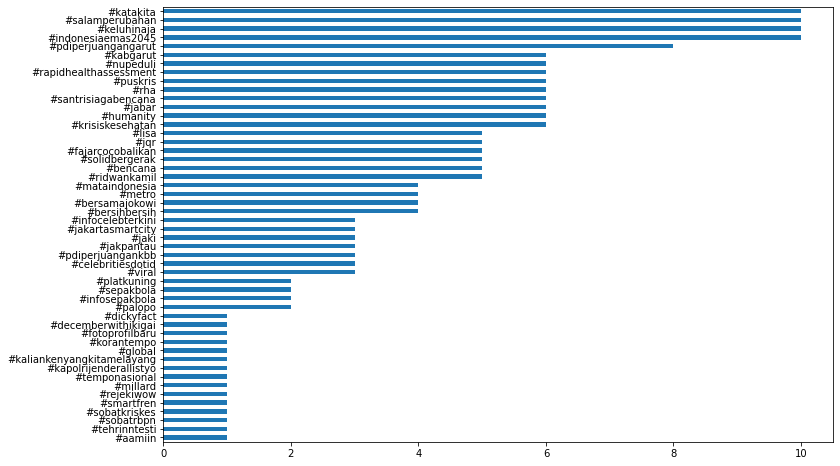

In [34]:
N = 50 # Number of top frequent hashtags to be plotted

dtHT = [x for t in tqdm(HT['hashtags']) for x in t] # any(h not in x for h in HTfilters)
dtHT = pd.Series(dtHT)
dtHT = dtHT.value_counts()
dtHT = dtHT.sort_index()
dtHT = dtHT.sort_values(ascending = True) 
dtHT.to_csv('hashTags_unp.csv', encoding='utf8')
dtHT = dtHT.iloc[:N]

p = dtHT.plot(kind='barh', figsize=(12,8), legend = False)

# Mengambil Data dari Seluruh Provinsi di Indonesia


In [19]:
import pandas as pd 

file = 'data/provinsi-latlon-radius.csv'
propinsi = pd.read_csv(file)
propinsi.head()

,propinsi,lat,lon,penduduk,radius
0,Provinsi Aceh,4.695135,96.749399,5459900,136
1,Provinsi Bali,-8.409518,115.188916,4380800,43
2,Provinsi Banten,-6.405817,106.064018,13160500,55
3,Provinsi Bengkulu,-3.577847,102.346388,2019800,79
4,Provinsi DI Yogyakarta,-7.875385,110.426209,3882300,32


<img alt="" src="images/brin/bencana-indonesia-2020.jpeg" />

In [20]:
# Load CSV Propinsi - keywords
# API Keys 
import brin

Ck = '' # consumer_key
Cs = '' # consumer_secret
At = '2214118411-i0MsjqZqjZ6uPfUplghxXcJsXdNYhRsCO82AnPW' # access_token
As = 'hxjsnKSY8dgv4Cl5gQd6M6Oax27U7xVoZrHnvSvRdBlCx' # access_secret
api = (Ck, Cs, At, As)

qry = 'banjir OR gempa OR longsor OR tsunami OR kekeringan OR abrasi OR erupsi'
tweet_, user_ = brin.getData(qry, N=300, prov=propinsi, lan='id', tKeys=api)

Mengambil sampel data dari:
Provinsi Aceh, Provinsi Bali, Provinsi Banten, Provinsi Bengkulu, Provinsi DI Yogyakarta, Provinsi DKI Jakarta, Provinsi Gorontalo, Provinsi Jambi, Provinsi Jawa Barat, Provinsi Jawa Tengah, Provinsi Jawa Timur, Provinsi Kalimantan Barat, Provinsi Kalimantan Selatan, Provinsi Kalimantan Tengah, Provinsi Kalimantan Timur, Provinsi Kalimantan Utara, Provinsi Kepulauan Bangka Belitung, Provinsi Kepulauan Riau, Provinsi Lampung, Provinsi Maluku, Provinsi Maluku Utara, Provinsi Nusa Tenggara Barat, Provinsi Nusa Tenggara Timur, Provinsi Papua, Provinsi Papua Barat, Provinsi Riau, Provinsi Sulawesi Barat, Provinsi Sulawesi Selatan, Provinsi Sulawesi Tengah, Provinsi Sulawesi Tenggara, Provinsi Sulawesi Utara, Provinsi Sumatera Barat, Provinsi Sumatera Selatan, Provinsi Sumatera Utara, 

 Finished Collecting 40864 samples of data about "banjir OR gempa OR longsor OR tsunami" from all provinces in Indonesia in 0 minutes


In [21]:
tweet_.head()

,created_at,screen_name,tweet,retweet_count,favorite_count,location,lat,lon
557,2021-11-30 12:58:26,AqseJuga,Hingga kini FPI masih sibuk di garut. Semoga k...,133,401,Provinsi Banten,-6.405817,106.064018
7106,2021-11-29 13:00:47,banjarbase,Yuk bantu saudara-saudara kita yang saat ini t...,86,73,Provinsi Kalimantan Selatan,-3.092642,115.283759
1295,2021-11-28 13:27:28,JogjaUpdate,Gempa peru Magnitudo 7.4 Mw terekam semua sens...,79,147,Provinsi DI Yogyakarta,-7.875385,110.426209
20912,2021-11-23 12:41:29,teoleeken,Bersama teman-teman turun ke Ampang untuk memb...,76,220,Provinsi Nusa Tenggara Timur,-8.657382,121.079370
40790,2021-11-29 19:47:40,bmkgwilayah2,"Info Gempa Mag:3.2, 30-Nov-21 02:38:54 WIB, Lo...",74,116,Provinsi Sumatera Utara,2.115355,99.545097


In [22]:
print("User di data dengan Follower terbanyak:")
user_.head(12)

User di data dengan Follower terbanyak:


,created_at,screen_name,name,followers_count,friends_count,description,id_str,location,lat,lon,protected,statuses_count,profile_image_url_https,verified,gender,age
538,2009-08-27 03:03:05,detikcom,detikcom,17257442,30,Official Twitter of https://t.co/qldGGYWfHu. r...,69183155,"Jakarta, Indonesia",-6.405817,106.064018,False,1904961,https://pbs.twimg.com/profile_images/143596072...,True,,0
549,2009-03-08 19:32:04,kompascom,Kompas.com,8280849,25,Jernih Melihat Dunia | Berita Indonesia Terkin...,23343960,Jakarta,-6.405817,106.064018,False,2014878,https://pbs.twimg.com/profile_images/143759126...,False,,0
566,2009-05-22 02:19:27,VIVAcoid,VIVAcoid,4423387,19,#1newstainment\n\nFOLLOW ⬇️⬇️⬇️\n@vivanewscom ...,41730943,"Jakarta, Indonesia",-6.405817,106.064018,False,1437531,https://pbs.twimg.com/profile_images/129302489...,True,,0
548,2009-06-16 10:48:24,liputan6dotcom,Liputan6.com,4093867,680,Download Apps Liputan6 di https://t.co/V7rwNkW...,47596019,Jakarta Indonesia,-6.405817,106.064018,False,1562843,https://pbs.twimg.com/profile_images/143378126...,True,,0
519,2009-06-15 06:14:53,okezonenews,Okezone,1790323,65,Official Twitter account of https://t.co/IoNM3...,47274731,Jakarta,-6.405817,106.064018,False,1844199,https://pbs.twimg.com/profile_images/132420812...,True,,0
599,2009-02-27 10:20:30,republikaonline,Republika.co.id,1681725,52,Akun Resmi Republika Online Info Buku Republi...,22126902,"Jakarta, Indonesia",-6.405817,106.064018,False,1748458,https://pbs.twimg.com/profile_images/123046952...,True,,0
1258,2010-03-31 09:48:11,JogjaUpdate,jogjaupdate.com,978697,64215,akun resmi dari https://t.co/VHDcafh1yq | berb...,128175561,Yogyakarta,-7.875385,110.426209,False,393645,https://pbs.twimg.com/profile_images/894435702...,True,,0
564,2011-02-22 05:45:38,hariankompas,Harian Kompas,899957,231,Amanat Hati Nurani Rakyat | Pendiri: PK Ojong ...,255866913,"Palmerah, Jakarta",-6.405817,106.064018,False,222086,https://pbs.twimg.com/profile_images/143665114...,True,,0
531,2015-09-11 02:47:49,KemensetnegRI,Sekretariat Negara,600185,169,Official Twitter Kementerian Sekretariat Negar...,3522129133,"Jakarta Pusat, DKI Jakarta",-6.405817,106.064018,False,25771,https://pbs.twimg.com/profile_images/643328450...,True,,0
4269,2009-07-21 18:48:20,pikiran_rakyat,Pikiran Rakyat,443923,24,Pikiran Rakyat Media Network\nKirimkan Foto/Vi...,58880688,"Bandung, Jawa Barat",-7.150975,110.140259,False,386026,https://pbs.twimg.com/profile_images/130145025...,True,,0


In [23]:
print("tweet dari user dengan retweet terbanyak")
d_ = tweet_[tweet_['retweet_count'] == tweet_['retweet_count'].max()]
print(d_.iloc[0].tweet)
d_.head(1)

tweet dari user dengan retweet terbanyak
Hingga kini FPI masih sibuk di garut. Semoga korban banjir bandang &amp; para relawan diberi sehat wal 'afiat. Aamiin. Ingat terus #6SyuhadaFPI https://t.co/EPJ8raXkwt


,created_at,screen_name,tweet,retweet_count,favorite_count,location,lat,lon
557,2021-11-30 12:58:26,AqseJuga,Hingga kini FPI masih sibuk di garut. Semoga k...,133,401,Provinsi Banten,-6.405817,106.064018


In [24]:
print("tweet dari user dengan Like terbanyak")
d_ = tweet_[tweet_['favorite_count'] == tweet_['favorite_count'].max()]
print(d_.iloc[0].tweet)
d_.head(1)

tweet dari user dengan Like terbanyak
Hingga kini FPI masih sibuk di garut. Semoga korban banjir bandang &amp; para relawan diberi sehat wal 'afiat. Aamiin. Ingat terus #6SyuhadaFPI https://t.co/EPJ8raXkwt


,created_at,screen_name,tweet,retweet_count,favorite_count,location,lat,lon
557,2021-11-30 12:58:26,AqseJuga,Hingga kini FPI masih sibuk di garut. Semoga k...,133,401,Provinsi Banten,-6.405817,106.064018


1457it [00:00, 32372.92it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<?, ?it/s]

Plot "30" HashTag terbanyak


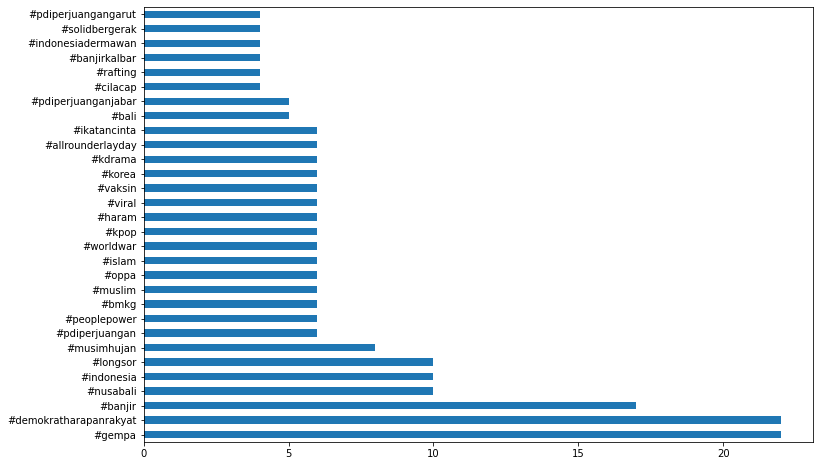

In [25]:
topHT = brin.hashTags(tweet_, N=30)

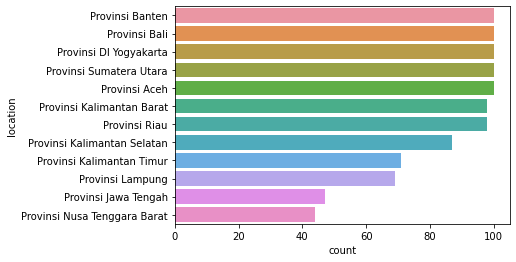

In [26]:
p = sns.countplot(y=tweet_.location, order=pd.value_counts(tweet_.location).iloc[:12].index)

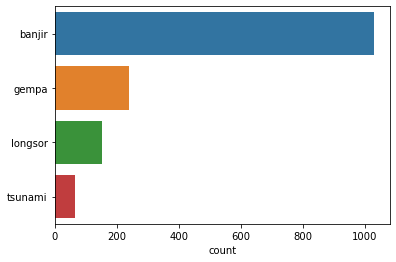

In [27]:
bencana = 'banjir gempa longsor tsunami'.split()
count_bencana = []
for b in bencana:
    for i, t in tweet_.iterrows():
        if b in t.tweet.lower():
            count_bencana.append(b)
p = sns.countplot(y=count_bencana, order=pd.value_counts(count_bencana).iloc[:len(bencana)].index)

In [28]:
import folium
from folium.plugins import MarkerCluster, HeatMap

def generateBaseMap(default_location=[-0.789275, 113.921], default_zoom_start=5):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

mp = generateBaseMap()
mp

In [29]:
# Gambar HeatMap di Peta , warna beda untuk tiap bencana
df_loc = brin.heatmap(tweet_)
base_map = generateBaseMap()
HeatMap(data=df_loc[['lat', 'lon', 'count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

1457it [00:00, 22076.48it/s]


In [30]:
# Gambar Peta Hashtags di Folium
mp = generateBaseMap()
ht_pos = brin.tagsMap(df_loc)
for propinsi, dt in ht_pos.items():
    try:
        latlon = dt[:2]
        pic = 'data/clouds/{}.png'.format(propinsi)
        icon = folium.features.CustomIcon(pic, icon_size=(100, 100))
        folium.Marker(latlon, popup=pic[:-4], icon=icon).add_to(mp)
    except:
        pass
mp

1457it [00:02, 642.13it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 28.40it/s]


# Topic Modelling

<p><img alt="" src="images/4_Document_to_Topics.png" style="height: 300px ; width: 582px" /></p>

<p><img alt="" src="images/4_definisi topic model.JPG" style="height:350px; width:809px" />

<p><img alt="" src="images/doc-topic-matrix.png" />

# Referensi Pilihan:

* perhitungan Manual Topic Modelling LDA: http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/
* http://mimno.infosci.cornell.edu/slides/details.pdf
* https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
* http://www.umiacs.umd.edu/~jbg/docs/nips2009-rtl.pdf
* http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
* Penjelasan intuitif yang baik: https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d 
* inconjunction dengan interactive program berikut: https://lettier.com/projects/lda-topic-modeling/ 

1457it [00:00, 2713.25it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.26s/it]


In total there are 2 major topics, distributed as follows


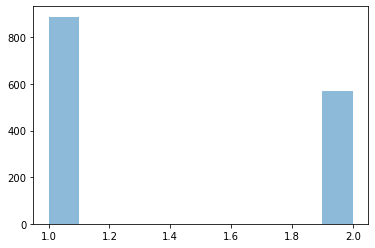

Printing top 2 Topics, with top 30 Words:
Topic #1:
banjir tidak longsor hujan kah air iya jalan tapi rumah jokowi tanah jakarta bendungan sumur demokrat nya kali korban rakyat semoga resapan gempa keluarga warga karalloe bandang sih banget ulama
Topic #2:
banjir gempa informasi bmkg bencana kabupaten mag lok kedlmn indonesia daerah warga desa terdampak wib tsunami kota korban bantuan kecamatan bandang sungai bpbd barat pgr garut november baratdaya wit masyarakat


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.151243  0.0       1        1  54.997316
1     -0.151243  0.0       2        1  45.002684, topic_info=            Term        Freq       Total Category  logprob  loglift
1741       tidak  209.000000  209.000000  Default  30.0000  30.0000
501        gempa  237.000000  237.000000  Default  29.0000  29.0000
615    informasi   86.000000   86.000000  Default  28.0000  28.0000
928      longsor  146.000000  146.000000  Default  27.0000  27.0000
245         bmkg   73.000000   73.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
829       korban   35.583359   73.604863   Topic2  -5.1684   0.0716
116      bandang   33.482858   63.126596   Topic2  -5.2292   0.1643
1630      sungai   31.899912   55.914713   Topic2  -5.2777   0.2372
490        garut   28.887455   44.966947   Topic2  -5.3769   0.3559
995   masyarakat   25.598828   41.920386   Topic2  -5.4977   0.3052

[129 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
15        1  0.966871      ahy
15        2  0.043949      ahy
16        1  0.805308      air
16        2  0.194385      air
31        1  0.039351     alam
...     ...       ...      ...
1836      2  0.614947    warga
1844      2  0.995098      wib
1845      1  0.041932  wilayah
1845      2  0.964446  wilayah
1849      2  0.989622      wit

[154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [31]:
# Pemodelan Topik
# Mari kita dalami lebih jauh Topic Pembicaraan ini
cleanTweet = brin.cleanTweet(tweet_)
tf_w, tm_w, vec_w = brin.getTopic(cleanTweet, Top_Words=30, resume_ = False)
pyLDAvis.sklearn.prepare(tf_w, tm_w, vec_w)  

# <center><font color="blue"> Akhir Modul B</font></center>

<hr />
<img alt="" src="images/meme-cartoon/.jpg" />